In [1]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import numpy as np
from submodlib import FacilityLocationFunction

In [2]:
import math

## Creation of Similarity Table and Subset Selection
First will create a similarity table consisting of cosine-similarity amongst the model representations. We will perform the following:
1. Extract the embeddings that were stored in pickle files.
2. Use the ids to join it with the table.
3. Then create the cosine-sim matrix.
For selecting the subset I will first do a run on 'Lazier than lazy greedy' selection algorithm for submodular maximization proposed by Mirzasoleiman et.al, 2015.


In [5]:
with open(os.path.join(os.path.expanduser('~/work/informed_undersampling/cmsb_run_1'), 'cmsb_embeds_1.pkl'), 'rb') as train_file:
    train_embeds = pickle.load(train_file)

In [6]:
df_train = pd.read_csv('sexist_data_final_train.csv')
df_train = df_train.drop(columns = ['Unnamed: 0']).reset_index(drop = True)
df_train.head()

,id,text,numeric_labels,sexist,predicted_label_1,correct_yx,predicted_label_2,predicted_label_3,predicted_label_4,predicted_label_5,average_pvi,average_el2n,average_vog,misclassification_number
0,2651,SIIIIGH http://t.co/BpJX5JwhlH,0,False,LABEL_0,True,LABEL_0,LABEL_0,LABEL_0,LABEL_0,0.134662,0.043008,-0.001590,0
1,6089,I really dislike working with undergrads in la...,0,False,LABEL_0,True,LABEL_0,LABEL_0,LABEL_0,LABEL_0,0.050947,0.119459,-0.001476,0
2,9786,"So calling qualified hires ""tokens"" b/c it's n...",0,False,LABEL_0,True,LABEL_0,LABEL_0,LABEL_0,LABEL_0,0.065549,0.104858,-0.000092,0
3,10635,Noooooo #mkr whyyyyy,0,False,LABEL_0,True,LABEL_0,LABEL_0,LABEL_0,LABEL_0,0.136266,0.041448,-0.001700,0
4,9749,I don't know ANY genuine female nerds... who w...,0,False,LABEL_0,True,LABEL_0,LABEL_1,LABEL_0,LABEL_0,-0.418783,0.439067,0.002268,1


In [7]:
df_train_sexist = df_train[df_train['sexist'] == True].reset_index(drop = True)
df_train_non_sexist = df_train[df_train['sexist'] == False].reset_index(drop = True)

In [8]:
def get_embeds(identities, ids_embeds):
    tensor = ids_embeds[identities[0]].unsqueeze(0)
    for identity in identities[1:]:
        tensor = torch.cat((tensor, ids_embeds[identity].unsqueeze(0)), dim  = 0)
    return tensor      

In [14]:
identities_data = df_train_sexist['id'].to_list()

In [9]:
identities_sexist = df_train_sexist['id'].to_list()
identities_non_sexist = df_train_non_sexist['id'].to_list()

In [10]:
embed_tensor_sexist = get_embeds(identities_sexist, train_embeds)
embed_tensor_non_sexist = get_embeds(identities_non_sexist, train_embeds)

In [15]:
embed_tensor_train = get_embeds(identities_data, train_embeds)

# Submodular Gain
We will use the concept of submodular gain, by modeling it as a monotone function in the mien of Facility Location.
For more details on Facility Location problem for Submodular optimization please visit the following link: https://arxiv.org/abs/2211.05474

In [11]:
 df_train_sexist.shape

(1269, 14)

In [12]:
df_train_non_sexist.shape

(8272, 14)

In [16]:
def get_subset(data, budget = 1000):
    objFL = FacilityLocationFunction(n = data.shape[0], data = data, mode = 'dense', metric = 'cosine')
    greedyList = objFL.maximize(budget = budget, optimizer = 'LazierThanLazyGreedy')
    return greedyList   

In [17]:
math.ceil(0.85 * embed_tensor_train.shape[0])

1079

In [18]:
greedy_subset_train = get_subset(data = embed_tensor_sexist, budget = 1000)

[||||||||||||||||||||]100% [Iteration 1000 of 1000]

In [13]:
greedy_sexist = get_subset(data = embed_tensor_sexist, budget = math.ceil(0.85 * embed_tensor_sexist.shape[0]))
greedy_non_sexist = get_subset(data = embed_tensor_non_sexist, budget = math.ceil(0.85 * embed_tensor_sexist.shape[0]))

[||||||||||||||||||||]100% [Iteration 1079 of 1079]

In [19]:
def get_data_types(misc_num):
    if misc_num <=3:
        return 'easy'
    else:
        return 'hard'

In [28]:
#type_data should be sexist or non-sexist
def get_dataframes_gains(subset, train_data, type_data):
    dict_id_gains = {'id': [], 'gains': []}
    for i, submodular_gain in subset:
        dict_id_gains['id'].append(train_data.iloc[i]['id'])
        dict_id_gains['gains'].append(submodular_gain)
    df_id_gains = pd.DataFrame(dict_id_gains)
    df_embeds = pd.read_csv('sexist_data_train_embeds.csv')
    print(df_embeds.columns)
    #df_embeds['type'] = df_embeds['misclassification_number'].apply(lambda x: get_data_types(x))
    df_gains_embeds = pd.merge(df_embeds, df_id_gains, on = 'id', how = 'inner')
    df_gains_embeds.to_csv(f'{type_data}_data_analysis.csv')
    return df_gains_embeds      

In [29]:
df_train_gains_embeds = get_dataframes_gains(greedy_subset_train, df_train, type_data = 'train')

Index(['id', 'text', 'sexist', 'numeric_labels', 'average_pvi', 'average_el2n',
       'average_vog', 'x', 'y', 'misclassification_number'],
      dtype='object')


In [35]:
df_train_gains_embeds.columns

Index(['id', 'text', 'sexist', 'numeric_labels', 'average_pvi', 'average_el2n',
       'average_vog', 'x', 'y', 'misclassification_number', 'gains'],
      dtype='object')

In [38]:
df_train_gains_embeds['type_data'] = df_train_gains_embeds['numeric_labels'].apply(
    lambda x: 'sexist' if x == 1 else 'non-sexist'
)

# Next Steps
1. Create a dataframe consisting of submodular gains and the corresponding i-scores
2. Analyze them to see how well they correlate (if submodular gains are there then the PVI also should also have more divergence)

# Cluster Analysis

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
def get_plots(data, type_data):
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'figure.figsize': (10, 10)})
    sns.set_theme(style="whitegrid")
    num_label = None
    if type_data == 'sexist':
        num_label = 1
    else:
        num_label = 0
    #markers = {'easy': 'x', 'hard': 'o'}
    color_palette = {'sexist': 'darkorange', 'counterfactual':'limegreen', 'non-sexist':'royalblue'}
    sns.scatterplot(data = data, x = 'x', y = 'y', hue = 'type_data', palette = color_palette, style = 'type_data', markers = {'sexist':'X', 'counterfactual': 's', 'non-sexist': 'o'}, s = 80)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.savefig(f'dataset_submod_distribution.pdf', bbox_inches = 'tight')
    plt.show()

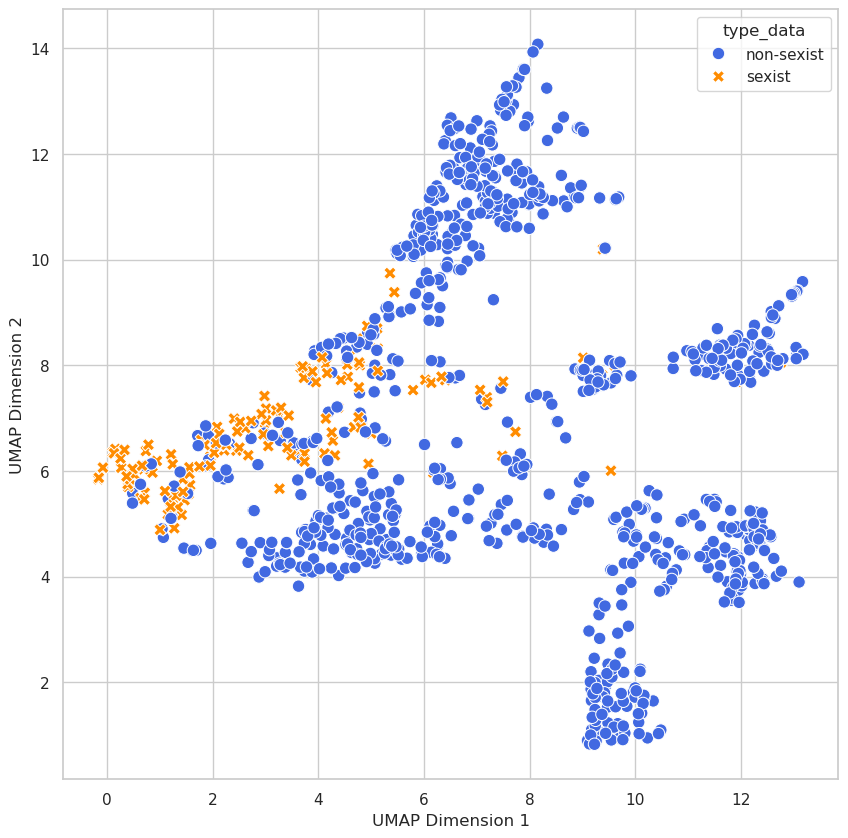

In [44]:
get_plots(df_train_gains_embeds, type_data = 'train')